# Guia de Prática 6

### 👉 Passos iniciais:

In [29]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
@author: Erick Nathan M. Alves & Victor Sidnei Cotta
@data: 15/11/2022
"""



#Importando as bibliotecas:
import numpy as np # importando biblioteca numpy
import matplotlib.pyplot as plt # importando biblioteca para plotar as figuras
import control as ct  #importando biblioteca python control systems

plt.close('all') #comando para fechar todas janelas de plot

#Exibição dos gráficos em janela externa:
#%matplotlib qt
#Exibição dos gráficos em no notebook:
%matplotlib inline



#Parâmetros do sistema:
La = .154
L1 = .155
Lt = .270
d = .02
m = .005
rho = 1.23
c = 2.05
mi = 5
g = 9.81

#Constantes do modelo:
K1 = ((d*rho*c*La*L1)/(2*m*(((Lt**2)/12)+(d**2))))
K2 = ((g*d)/(((Lt**2)/12)+(d**2)))
K3 = ((mi*d**2)/(m*(((Lt**2)/12)+(d**2))))

#Dinâmica do sistema:
X0 = [0, 0] #condições iniciais

#Caracterizando o modelo, em espaço de estados:
def model_update(t, x, u, params):
    
    x1 = x[0] # posicao
    x2 = x[1] # velocidade

    #Retorna as derivadas:
    return [x2, ((K1*(np.cos(x1)**2)*u[0]) - ((K2*np.sin(x1)) + (K3*x2)))]

#Função que retorna o estado:
def model_output(t, x, u, params):
    return x

#Instanciando o sistema:
fanplate = ct.NonlinearIOSystem(model_update, model_output, states=2, name='fanplate', inputs=('u'), outputs=('x1','x2'))

### -> Item 2:

* Levando o sistema ao ponto de operação (27°):

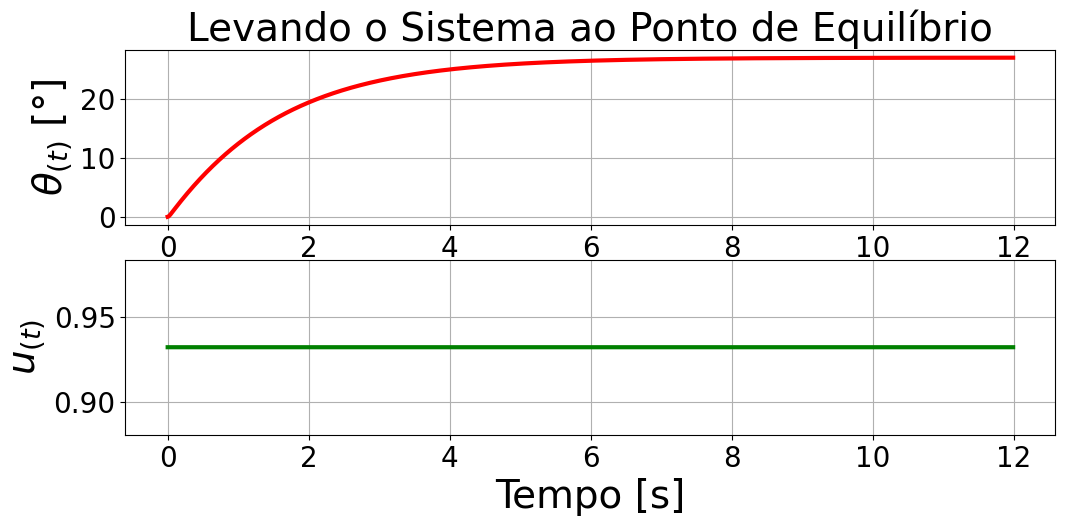

In [30]:
#Parâmetros de simulação:
t = np.arange(0, 12, .01) #criando array de tempo
pop = 27 #Posição de equilíbrio em graus
u_eq = (((K2/K1)*np.sin(np.radians(pop)))/(np.cos(np.radians(pop))**2)) #sinal que leva ao ponto desejado
u = u_eq*np.ones(t.shape) #criando array com para o sinal

#Solucionando o sistema em si:
t, x = ct.input_output_response(fanplate, t, u, X0=X0)
y = x[0]

#Plotando o resultado da simulação-------------------------------------------------------------------
plt.figure(1)
plt.rcParams['figure.figsize'] = (12, 5)
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.subplot(2, 1, 1)
plt.plot(t, np.degrees(y),'r', label='$\\theta_{(t)}$', linewidth=3)
plt.ylabel('$\\theta_{(t)}$ [°]', fontsize=28)
plt.title('Levando o Sistema ao Ponto de Equilíbrio', fontsize=28)
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(t, u, 'g', label='$u_{(t)}$', linewidth=3)
plt.ylabel('$u_{(t)}$', fontsize=28)
plt.xlabel('Tempo [s]', fontsize=28)
plt.grid()
plt.show()

* Aplicação de um degrau de +5° em torno do equilíbrio:

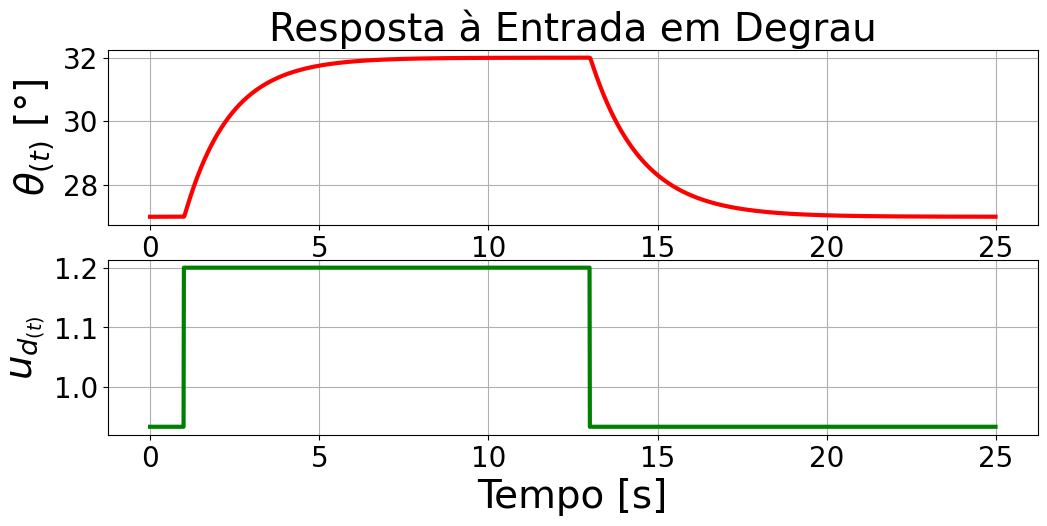

In [31]:
#Parâmetros de simulação:
X0 = [np.radians(27), 0]
kd = 5
ud = (((K2/K1)*np.sin(np.radians(pop+kd)))/(np.cos(np.radians(pop+kd))**2)) #sinal que aplica o degrau
td = np.arange(0, 25, .01) #criando array de tempo
#Criação do degrau:
u = np.hstack(((u_eq*np.ones(100)), (ud*np.ones(1200)), (u_eq*np.ones(1200))))    

#Solucionando o sistema em si:
td, xd = ct.input_output_response(fanplate, td, u, X0=X0)
yd = xd[0]

#Plotando o resultado da simulação-------------------------------------------------------------------
plt.figure(2)
plt.rcParams['figure.figsize'] = (12, 5)
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.subplot(2, 1, 1)
plt.plot(td, np.degrees(yd),'r', label='$\\theta_{(t)}$', linewidth=3)
plt.ylabel('$\\theta_{(t)}$ [°]', fontsize=28)
plt.title('Resposta à Entrada em Degrau', fontsize=28)
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(td, u, 'g', label='$u_{d_{(t)}}$', linewidth=3)
plt.ylabel('$u_{d_{(t)}}$', fontsize=28)
plt.xlabel('Tempo [s]', fontsize=28)
plt.grid()
plt.show()

* Obtenção dos parâmetros para modelo de Ziegler-Nichols, por resposta ao degrau positivo (borda de subida):


 Resposta ao degrau (+5º): 	A = 1	 B = 1.9606	 C = 2.5212


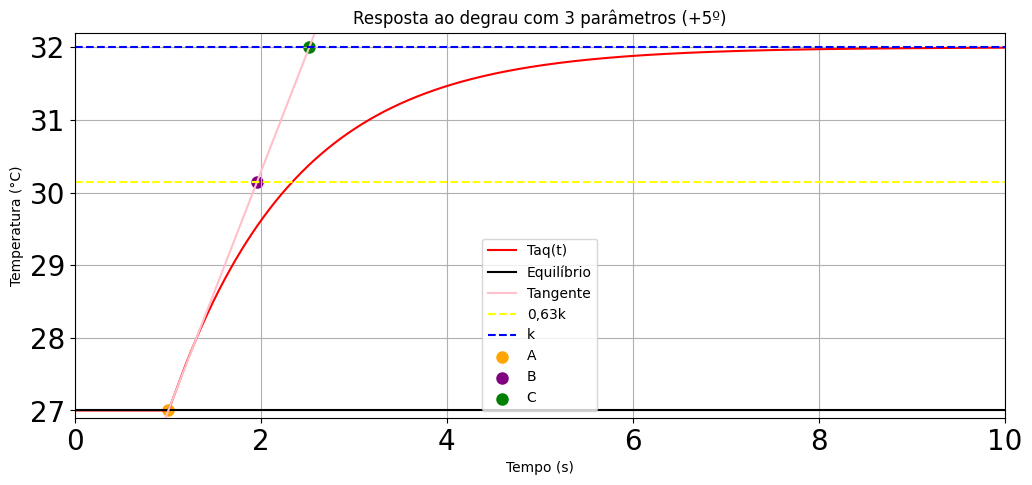

In [32]:
#Equilíbrio:
y0 = (pop*np.ones(td.shape))

#Reta tangente:
coef_ang = 3.3
coef_lin = 23.68
y1 = (coef_ang*td + coef_lin) #ajustada graficamente

#Atraso / tempo morto / fase:
A = 1 #obtido graficamente (há uma antecipação que não existe, o atraso é zero aqui, portanto o tempo morto também é zero)!!!!!!!!!!!!!!!

#Reta 0,63K:
y2 = ((pop+(0.63*kd))*np.ones(td.shape))
B = (((pop+(0.63*kd))-coef_lin)/coef_ang)

#Reta K:
y3 = ((pop+kd)*np.ones(td.shape))
C = (((pop+kd)-coef_lin)/coef_ang)

print("\n Resposta ao degrau (+5º): \tA = " + str(round(A, 4)) + "\t B = " + str(round(B, 4)) + "\t C = " + str(round(C, 4)))

#Plotando o resultado da simulação-------------------------------------------------------------------
plt.figure(3)
plt.rcParams['figure.figsize'] = (12, 5)
plt.plot(td, np.degrees(yd),'red',label='Taq(t)')
plt.plot(td, y0,'black',label='Equilíbrio')
plt.plot(td, y1,'pink',label='Tangente')
plt.plot(td, y2,'yellow',ls='--',label='0,63k')
plt.plot(td, y3,'blue',ls='--',label='k')
plt.scatter(A, 27, c='orange', linewidths=3, label='A')
plt.scatter(B, (27+(0.63*5)), c='purple', linewidths=3, label='B')
plt.scatter(C, 32, c='green', linewidths=3, label='C')
plt.ylabel('Temperatura (°C)')
plt.xlabel('Tempo (s)')
plt.xlim(0, 10)
plt.legend()
plt.ylim(26.9, 32.2)
plt.title('Resposta ao degrau com 3 parâmetros (+5º)')
plt.grid()
plt.show()

* Validação do modelo:


 TAU: 	 1.5212

G: 
  0.3245
-----------
1.521 s + 1



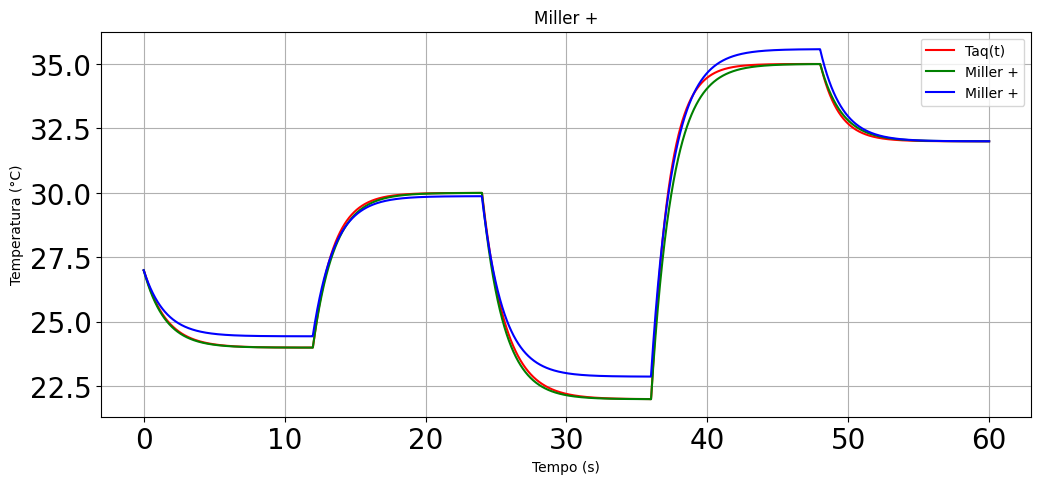

In [33]:
#Resposta ao degrau:
tau = (C-A)
print(f'\n TAU: \t {round(tau, 4)}')
theta = 0
def sd(t, k, tau, theta):
    return (k*(1-np.exp((theta-t)/tau)))

#Criação de degraus:
udeg = []
kdeg = [-3, 3, -5, 8, 5]
for i in range(len(kdeg)):
    udeg.append((((K2/K1)*np.sin(np.radians(pop+kdeg[i])))/(np.cos(np.radians(pop+kdeg[i]))**2))*np.ones(1200))
uv = np.hstack(udeg)

tv = np.arange(0, 60, .01)

ysv = np.hstack(((pop+sd(tv[:1200], -3, tau, theta)), ((pop+kdeg[0])+sd(tv[:1200], 6, tau, theta)), ((pop+kdeg[1])+sd(tv[:1200], -8, tau, theta)), ((pop+kdeg[2])+sd(tv[:1200], 13, tau, theta)), ((pop+kdeg[3])+sd(tv[:1200], -3, tau, theta))))

#Parâmetros de simulação:
X0 = [np.radians(pop), 0]

#Solucionando o sistema em si:
tv, xv = ct.input_output_response(fanplate, tv, uv, X0=X0)
yv = np.degrees(xv[0])

#Função de transferência para um sistema de primeira ordem superamortecido:
s = ct.tf('s')
K = (np.radians(kd)/(ud-u_eq)) #ganho estático do sistema
G = (K/((tau*s)+1))
print('\nG: ' + str(G))

tv, xft = ct.forced_response(G, T=tv, U=(uv-u_eq))
yft = (np.degrees(xft)+27)

#Plotando o resultado da simulação-------------------------------------------------------------------
plt.figure(4)
plt.rcParams['figure.figsize'] = (12, 5)
plt.plot(tv, yv, 'red', label='Taq(t)')
plt.plot(tv, ysv,'green',label='Miller +')
plt.plot(tv, yft,'blue',label='Miller +')
plt.ylabel('Temperatura (°C)')
plt.xlabel('Tempo (s)')
#plt.xlim(350, tf)
plt.legend()
#plt.ylim(70, 90)
plt.title('Miller +')
plt.grid()
plt.show()

### Item 3:

* Inclusão do atraso ao modelo obtido:

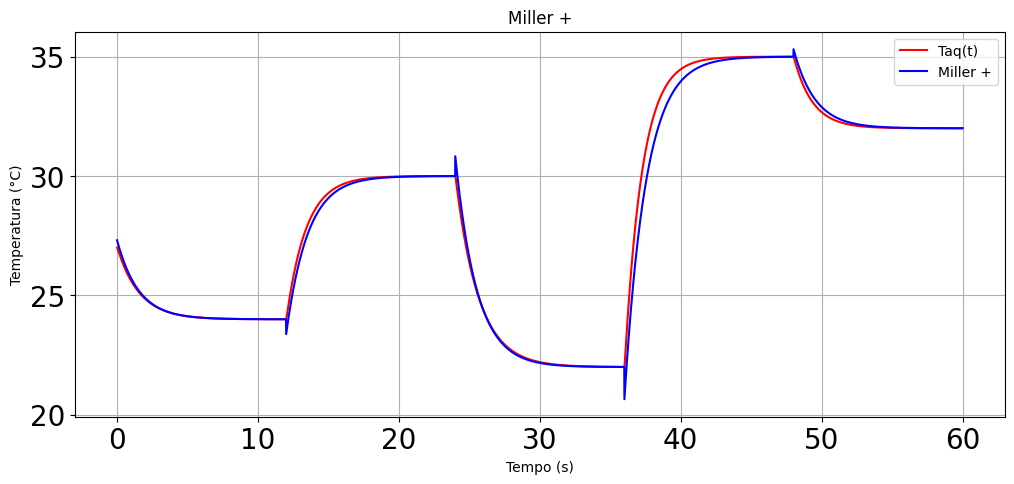

In [34]:
theta = 0.15

td1 = np.arange(0, 60, .01)

yd1 = np.hstack(((pop+sd(tv[:1200], -3, tau, theta)), ((pop+kdeg[0])+sd(tv[:1200], 6, tau, theta)), ((pop+kdeg[1])+sd(tv[:1200], -8, tau, theta)), ((pop+kdeg[2])+sd(tv[:1200], 13, tau, theta)), ((pop+kdeg[3])+sd(tv[:1200], -3, tau, theta))))

#Parâmetros de simulação:
X0 = [np.radians(pop), 0]

#Plotando o resultado da simulação-------------------------------------------------------------------
plt.figure(5)
plt.rcParams['figure.figsize'] = (12, 5)
plt.plot(tv, yv, 'red', label='Taq(t)')
plt.plot(tv, yd1,'blue',label='Miller +')
plt.ylabel('Temperatura (°C)')
plt.xlabel('Tempo (s)')
#plt.xlim(350, tf)
plt.legend()
#plt.ylim(70, 90)
plt.title('Miller +')
plt.grid()
plt.show()

### Itens 4 e 5:

* Incluindo atraso por aproximação de Padé (ordens: 1, 3, 5 e 9):

In [35]:
#Funções de transferência das ordens especificadas:
Gd = []
o_p = [1, 3, 5, 9]
for i in range(len(o_p)):
    #Aproximação de padé:
    N = ct.pade(0.15, o_p[i])
    #Função de transferência do atraso:
    Gd.append(ct.TransferFunction(np.array(N[0]), np.array(N[1])))
    print(f'\n Gd{o_p[i]}: \t {Gd[i]}')


 Gd1: 	 
-s + 13.33
----------
s + 13.33


 Gd3: 	 
-s^3 + 80 s^2 - 2667 s + 3.556e+04
----------------------------------
s^3 + 80 s^2 + 2667 s + 3.556e+04


 Gd5: 	 
-s^5 + 200 s^4 - 1.867e+04 s^3 + 9.956e+05 s^2 - 2.987e+07 s + 3.982e+08
------------------------------------------------------------------------
s^5 + 200 s^4 + 1.867e+04 s^3 + 9.956e+05 s^2 + 2.987e+07 s + 3.982e+08


 Gd9: 	 
-s^9 + 600 s^8 - 1.76e+05 s^7 + 3.285e+07 s^6 - 4.271e+09 s^5 + 3.986e+11 s^4 - 2.657e+13 s^3 + 1.215e+15 s^2 - 3.442e+16 s + 4.589e+17
---------------------------------------------------------------------------------------------------------------------------------------
s^9 + 600 s^8 + 1.76e+05 s^7 + 3.285e+07 s^6 + 4.271e+09 s^5 + 3.986e+11 s^4 + 2.657e+13 s^3 + 1.215e+15 s^2 + 3.442e+16 s + 4.589e+17



### Item 6:

* Simulação do sistema com atraso:

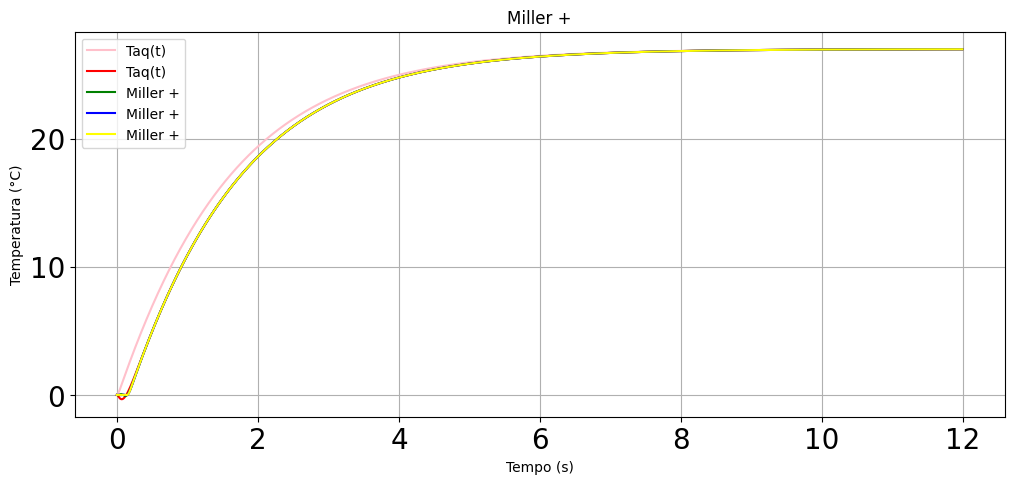

In [36]:
y_malha = []
u = u_eq*np.ones(t.shape) #criando array com para o sinal
for i in range(4):
    atraso = ct.tf2io(Gd[i], name='atraso', inputs='u', outputs='y')
    malha = ct.InterconnectedSystem(
        (atraso, fanplate), name='malha', 
        connections=(('atraso.u',), ('fanplate.u', 'atraso.y')), 
        inplist=('atraso.u'),
        outlist=('fanplate.x1', 'fanplate.x2')
    )
    X0 = np.zeros(o_p[i]+2)

    t, ym = ct.input_output_response(malha, t, u, X0)
    y_malha.append(ym[0])

#Parâmetros de simulação:
X0 = [0, 0]
tn = np.arange(0, 12, .01) #criando array de tempo
u = u_eq*np.ones(t.shape) #criando array com para o sinal

#Solucionando o sistema em si:
tn, x = ct.input_output_response(fanplate, tn, u, X0=X0)
y = x[0]

#Plotando o resultado da simulação-------------------------------------------------------------------
plt.figure(6)
plt.rcParams['figure.figsize'] = (12, 5)
plt.plot(tn, np.degrees(y), 'pink', label='Taq(t)')
plt.plot(t, np.degrees(y_malha[0]), 'red', label='Taq(t)')
plt.plot(t, np.degrees(y_malha[1]),'green',label='Miller +')
plt.plot(t, np.degrees(y_malha[2]),'blue',label='Miller +')
plt.plot(t, np.degrees(y_malha[3]),'yellow',label='Miller +')
plt.ylabel('Temperatura (°C)')
plt.xlabel('Tempo (s)')
#plt.xlim(350, tf)
plt.legend()
#plt.ylim(70, 90)
plt.title('Miller +')
plt.grid()
plt.show()


### Item 7:

* Comparação resposta ao degrau com atraso, por aproximação de Padé de 5ª ordem:

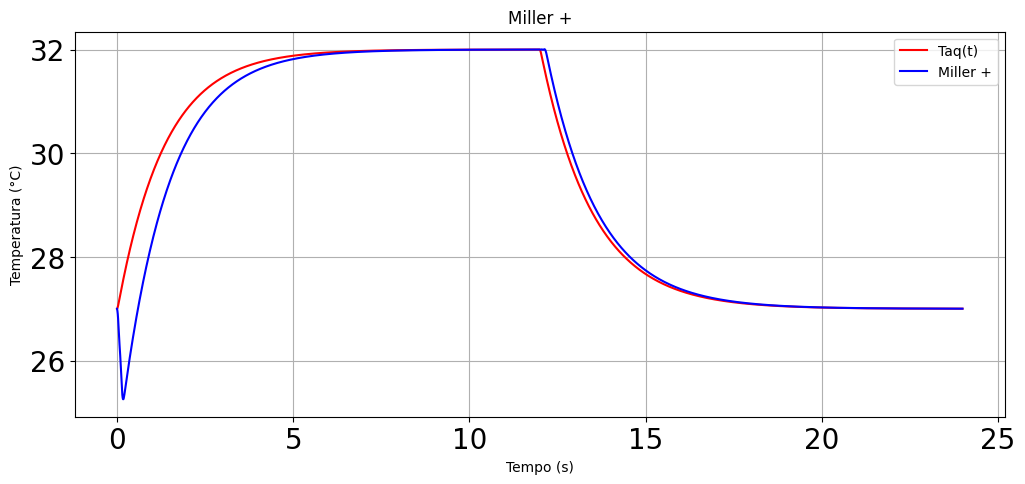

In [37]:
#Parâmetros de simulação:
X0 = [np.radians(pop), 0]

#Criação do degrau:
u = np.hstack(((ud*np.ones(1200)), (u_eq*np.ones(1200)))) 
t = np.arange(0, 24, .01) #criando array de tempo

#Solucionando o sistema em si:
t, xdeg = ct.input_output_response(fanplate, t, u, X0=X0)
ydeg = xdeg[0]

atraso = ct.tf2io(Gd[2], name='atraso', inputs='u', outputs='y')
malha = ct.InterconnectedSystem(
    (atraso, fanplate), name='malha', 
    connections=(('atraso.u',), ('fanplate.u', 'atraso.y')), 
    inplist=('atraso.u'),
    outlist=('fanplate.x1', 'fanplate.x2')
)
X0 = np.array([0, 0, 0, 0, 0, np.radians(pop), 0])

t, xm = ct.input_output_response(malha, t, u, X0)
y_md = xm[0]

#Plotando o resultado da simulação-------------------------------------------------------------------
plt.figure(7)
plt.rcParams['figure.figsize'] = (12, 5)
plt.plot(t, np.degrees(ydeg), 'red', label='Taq(t)')
plt.plot(t, np.degrees(y_md),'blue',label='Miller +')
plt.ylabel('Temperatura (°C)')
plt.xlabel('Tempo (s)')
#plt.xlim(350, tf)
plt.legend()
#plt.ylim(70, 90)
plt.title('Miller +')
plt.grid()
plt.show()

### Itens 8:

* Controlador Proporcional - Ziegler Nichols:

In [38]:
# Constantes via parâmetros de Ziegler Nichols - Tabelas 8.6 e 8.7 (Garcia, 2017):
Kc_pzn = (tau/(np.radians(kd)*theta))
print(f'\nKc: \t {round(Kc_pzn, 4)}')


Kc: 	 116.212


* Controlador Proporcional - CHR:

In [39]:
# Constantes via parâmetros de CHR - Tabela 8.9 (Garcia, 2017):
Kc_pchr = ((0.3*tau)/(np.radians(kd)*theta))
print(f'\nKc: \t {round(Kc_pchr, 4)}')


Kc: 	 34.8636


* Controlador Proporcional Integral - Ziegler Nichols:

In [40]:
# Constantes via parâmetros de Ziegler Nichols - Tabelas 8.6 e 8.7 (Garcia, 2017):
Kc_pizn = ((0.9*tau)/(np.radians(kd)*theta))
Ti_pizn = ((10*theta)/3)
print(f'\nKc: \t {round(Kc_pizn, 4)}')
print(f'\nTi: \t {round(Ti_pizn, 4)}')


Kc: 	 104.5908

Ti: 	 0.5


* Controlador Proporcional Integral - CHR:

In [41]:
# Constantes via parâmetros de CHR - Tabela 8.9 (Garcia, 2017):
Kc_pichr = ((0.6*tau)/(kd*theta))
Ti_pichr = (4*theta)
print(f'\nKc: \t {round(Kc_pichr, 4)}')
print(f'\nTi: \t {round(Ti_pichr, 4)}')


Kc: 	 1.217

Ti: 	 0.6


### Item 10:

* Resposta em malha fechada r = [0 1 0 −1 0.5 1 −0.5 0]:

In [42]:
#Array de tempo:
t = np.arange(0, 96, .01)

#Preparando o sinal de referência:
r0 = [0, 1, 0, -1, 0.5, 1, -0.5, 0]
rs = []
us = []
for i in range(len(r0)):
    ri = np.radians(pop+(kd*r0[i]))
    rs.append(ri*np.ones(1200))
    us.append((((K2/K1)*np.sin(ri))/(np.cos(ri)**2))*np.ones(1200))
r = np.hstack(rs)
u = np.hstack(us)

#Preparando o sinal de controle de operação:
u0 = u_eq*np.ones(t.shape)

#Preparando os controladores:

#Definição das funções de transferência:
ft_pzn = ct.tf(Kc_pzn, 1) # P - Ziegler Nichols
ft_pchr = ct.tf(Kc_pchr, 1) # P - CHR
ft_pizn1 = ct.tf(Kc_pizn, 1) # PI - Ziegler Nichols (Parte Proporcional)
ft_pizn2 = (Ti_pizn/s) # PI - Ziegler Nichols (Parte Integral)
ft_pichr1 = ct.tf(Kc_pichr, 1) # PI - CHR (Parte Proporcional)
ft_pichr2 = (Ti_pichr/s) # PI - CHR (Parte Integral)

#Definindo os subsistemas em formato de entradas e saídas:
sys_pzn = ct.tf2io(ft_pzn, name='pzn', inputs='u', outputs='y')
sys_pchr = ct.tf2io(ft_pchr, name='pchr', inputs='u', outputs='y')
sys_pizn1 = ct.tf2io(ft_pizn1, name='pizn1', inputs='u', outputs='y')
sys_pizn2 = ct.tf2io(ft_pizn2, name='pizn2', inputs='u', outputs='y')
sys_pichr1 = ct.tf2io(ft_pichr1, name='pichr1', inputs='u', outputs='y')
sys_pichr2 = ct.tf2io(ft_pichr2, name='pichr2', inputs='u', outputs='y')

# Atraso:
atraso = ct.tf2io(Gd[-2], name='atraso', inputs='u', outputs='y')

#Conexão das malhas:

# Controlador Proporcional - Ziegler Nichols:
malha1 = ct.InterconnectedSystem(
    (fanplate, atraso, sys_pzn), name='malha1', 
    connections=(('pzn.u', '-fanplate.x1'), ('atraso.u', 'pzn.y'), ('fanplate.u', 'atraso.y')), 
    inplist=('pzn.u', 'atraso.u'),
    inputs=('xref', 'u0'),
    outlist=('fanplate.x1', 'fanplate.x2', 'fanplate.u'),
    outputs=('x1', 'x2', 'u')
)

# Malha aberta:
X0 = [np.radians(pop), 0]
t, xout = ct.input_output_response(fanplate, t, u, X0)
ma = xout[0]

# Malha fechada:
X0 = np.array([0, 0, 0, 0, 0, np.radians(pop), 0])
t, xout = ct.input_output_response(malha1, t, [r, u0], X0)
cpzn = xout[0]

#Plotando o resultado da simulação-------------------------------------------------------------------
plt.figure(8)
plt.rcParams['figure.figsize'] = (12, 5)
plt.subplot(2, 1, 1)
plt.plot(t, np.degrees(ma), 'red', label='Taq(t)')
plt.plot(t, np.degrees(cpzn),'blue',label='Miller +')
plt.ylabel('Temperatura (°C)')
#plt.xlabel('Tempo (s)')
#plt.xlim(350, tf)
plt.legend()
#plt.ylim(70, 90)
plt.title('Miller +')
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(t, xout[2], 'green', label='Taq(t)')
plt.ylabel('Temperatura (°C)')
plt.xlabel('Tempo (s)')
#plt.xlim(350, tf)
plt.legend()
#plt.ylim(70, 90)
plt.grid()
plt.show()


KeyboardInterrupt: 

* Rejeição a perturbação:

### Item 12:

* Performance da malha fechada: